# 1. Summary

#### Aim:
To explore and understand the features that are associated with fraudulent transactions. It is of our interest to build a model to classify/detect fraudulent transactions.

#### Data:
- A data set with 96510 samples and 22 features was used for this analysis. The target variable of interest is is_fraud (0/1). 0 represents genuine transaction and 1 represents fraudulent transaction. 
- There were no missing data. Personally identifiable information (PII) data such as cc number, first name, last name, address, etc. were de-scoped from the data analysis and modelling.
- Categorical features such as merchant, state, city and job title were dropped/not included for modelling as it may lead to biased outcomes.
- The feature - number of fraud transactions in 24h was excluded, as this would have resulted in data leakage.
- New features were created based of time-series date & time feature, particularly, month and year.
- Train-test split: 70-30.

#### Methods:

- The target feature was imbalanced. The imbalance ratio was 9:1, i.e., for every 10 trans. 1 trans. was fraudulent. Class weights - 0:0.09 and 1:0.91 were used to deal with the imbalance. More weight was given to fraudulent transactions.

- Logistic regression (with class weights) was employed using recursive feature selection with cross-validation,

- Naive Bayes classifier,

- Support Vector Machine (SVM),

- k-NN.

- Best set of features determined by logistic regression:

    - $logit(is fraud_i) = \beta_0 + \beta_1 * category.grocery.pos + \beta_2 * amount + \beta_3 * num.trans.60d + \beta_4 * num.trans.24h + \beta_5 * avg.trans.amt.60d + \epsilon_i$

#### Results and findings:

- Performance metrics:
    - F1-Score (Macro): 
        - Logistic regression: 74%,
        - Naive Bayes classifier: 84%,
        - SVM: 86%,
        - k-NN: 88%.

- Both SVM and k-NN does a better job in classifying both fraudulent and genuine transactions compared to logistic regression and Naive Bayes classifier. 
    - There are some trade-offs between the mis-classification rates - false positives and false negatives. 
        - SVM and k-NN mis-classification rates are the lowest compared to Logistic regression and Naive Bayes classifier.
        - k-NN is good for precision and recall of legit. trans, and SVM is better for precision and recall of fraudulent trans.

- Our aim was to build a classification model to detect fraudulent transactions, SVM classifier is doing a better job compared to logistic regression, Naive-Bayes classification and k-NN models.

# 2. Technical notes

### a. Exploratory data analysis

In [179]:
!python --version

# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

import scipy
import statsmodels.api as sm

import sklearn
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import RFECV


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore") # Suppress all warnings


Python 3.11.2


##### Read in the data 

In [180]:
data = pd.read_csv('\\DATA\\fraud_data.csv', index_col=False)

##### Inspect the data

In [181]:
# view top 5 rows
data.head(5)

,trans_datetime,cc_num,merchant,category,amount,firstname,lastname,gender,street,city,...,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
0,2019-01-01 00:14:37,2305336922781618,Harris Inc,gas_transport,50.79,Jeffrey,Rice,M,21447 Powell Circle,Moulton,...,40.6866,-92.6833,1132,Probation officer,58,1,6,0,50.79,0
1,2019-01-01 00:18:06,4428780983793657331,Lesch Ltd,shopping_pos,22.95,Richard,Waters,M,7683 Natasha Way Apt. 945,Waukesha,...,42.9993,-88.2196,95015,"Therapist, occupational",73,1,8,0,22.95,0
2,2019-01-01 00:40:50,213178850083780,Cummerata-Jones,gas_transport,70.53,Shawn,King,M,31493 Garcia Summit,Athena,...,45.8289,-118.4971,1302,Dealer,42,1,6,0,52.48,0
3,2019-01-01 00:47:55,3525668150756629,Heathcote LLC,shopping_net,101.35,Christopher,Choi,M,04611 Sandra Spring Suite 059,Rumely,...,46.3481,-87.0436,137,Film/video editor,28,424,5,0,69.34,0
4,2019-01-01 01:02:16,376028110684021,Wolf Inc,grocery_pos,89.11,Aaron,Murray,M,624 Hale Springs Apt. 572,Meadville,...,39.7795,-93.3014,964,Tourist information centre manager,44,1,3,0,66.03,0


In [182]:
# view bottom 5 rows
data.tail(5)

,trans_datetime,cc_num,merchant,category,amount,firstname,lastname,gender,street,city,...,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
96505,2020-12-31 22:57:18,6011652924285713,McKenzie-Huels,food_dining,1.52,Kathryn,Smith,F,19838 Tonya Prairie Apt. 947,Rocky Mount,...,38.2911,-92.7059,1847,Tax inspector,32,498,15,0,61.12,0
96506,2020-12-31 23:11:13,3575789281659026,"Crist, Jakubowski and Littel",home,140.82,Lindsay,Wilson,F,7618 Gonzales Mission,Centerview,...,38.7897,-93.8702,2368,Electronics engineer,31,498,14,0,54.80,0
96507,2020-12-31 23:12:52,60490596305,Thiel-Thiel,entertainment,173.99,Karen,Johnson,F,4349 Anna Flat Suite 214,Haynes,...,34.8838,-90.7666,222,"Programmer, applications",58,170,2,0,71.76,0
96508,2020-12-31 23:32:19,6544734391390261,Bernier and Sons,kids_pets,29.11,John,Myers,M,701 Wilson Divide,Highland,...,41.5500,-87.4569,23727,Community arts worker,39,251,5,0,53.70,0
96509,2020-12-31 23:35:28,4642255475285942,Dickinson-Rempel,misc_pos,5.58,Sabrina,Johnson,F,320 Nicholson Orchard,Thompson,...,38.9999,-109.6150,46,"Surveyor, minerals",34,507,9,0,60.55,0


In [183]:
# shape
data.shape

(96510, 22)

In [184]:
# information about data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96510 entries, 0 to 96509
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_datetime       96510 non-null  object 
 1   cc_num               96510 non-null  int64  
 2   merchant             96510 non-null  object 
 3   category             96510 non-null  object 
 4   amount               96510 non-null  float64
 5   firstname            96510 non-null  object 
 6   lastname             96510 non-null  object 
 7   gender               96510 non-null  object 
 8   street               96510 non-null  object 
 9   city                 96510 non-null  object 
 10  state                96510 non-null  object 
 11  zip                  96510 non-null  int64  
 12  lat                  96510 non-null  float64
 13  lon                  96510 non-null  float64
 14  city_pop             96510 non-null  int64  
 15  job                  96510 non-null 

In [185]:
# missing values
data.isna().sum()

trans_datetime         0
cc_num                 0
merchant               0
category               0
amount                 0
firstname              0
lastname               0
gender                 0
street                 0
city                   0
state                  0
zip                    0
lat                    0
lon                    0
city_pop               0
job                    0
age                    0
num_trans_60d          0
num_trans_24h          0
num_fraud_trans_24h    0
avg_trans_amt_60d      0
is_fraud               0
dtype: int64

In [186]:
# missing values
data.isnull().sum()

trans_datetime         0
cc_num                 0
merchant               0
category               0
amount                 0
firstname              0
lastname               0
gender                 0
street                 0
city                   0
state                  0
zip                    0
lat                    0
lon                    0
city_pop               0
job                    0
age                    0
num_trans_60d          0
num_trans_24h          0
num_fraud_trans_24h    0
avg_trans_amt_60d      0
is_fraud               0
dtype: int64

Comments:

- The data set has 96510 samples and 22 features.

- Data definitions:
    - trans_datetime - time-series representing date and time of the transaction.
    - cc_num - credit card number.
    - merchant - name of the merchant.
    - category - retail category associated with the transaction.
    - amount - amount spent, assume it's in USD.
    - firstname - first name of the cardholder.
    - lastname - last name of the cardholder.
    - gender - gender of the cardholder.
    - street - address of the cardholder.
    - city - city of the cardholder.
    - state - state of the cardholder.
    - zip - postal code of the cardholder.
    - lat - latitude of the cardholder's location.
    - lon - longitute of the cardholder's location.
    - city_pop - assume it's population of the city.
    - job - job title of the cardholder.
    - age - age of the cardholder.
    - num_trans_60d - number of transactions in the last 60 days.
    - num_trans_24h - number of transactions in the last 24 hours.
    - num_fraud_trans_24h - number of fraudulent transactions in the last 24 hours.
    - avg_trans_amt_60d - mean spend on transactions in the last 60 days.
    
- Target feature:
    - is_fraud - 0 represents no, 1 represents yes or i.e., a fraudulent transaction.

- Data quality:
    - There are no missing data.

- Data governance:
    - There are personally identifiable information (PII) such as cc_num, firstname, lastname, street, zip, lat and lon. Let's remove these columns, as it contains sensititve data. Ideally, these columns should be treated and anonymised or masked using PII catcher.

- Feature engineering:
    - see if there are interesting pattern with 
        - time-series - create month as a feature.


Drop the personally identifiable information columns

In [187]:
data.drop(columns=['cc_num', 'firstname', 'lastname', 'street', 'zip', 'lat', 'lon'], axis=1, inplace=True)

##### Descriptive statistics

In [188]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,amount,city_pop,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
count,96510.00000,96510.00000,96510.00000,96510.00000,96510.00000,96510.00000,96510.00000,96510.00000
mean,113.80574,90257.61371,46.54191,198.85989,5.10019,0.37360,71.68925,0.10000
std,224.21343,304683.77615,17.63374,100.35401,3.19652,1.37398,37.23589,0.30000
min,1.00000,23.00000,14.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,11.09000,743.00000,33.00000,123.00000,3.00000,0.00000,54.67000,0.00000
50%,51.61000,2471.00000,44.00000,194.00000,4.00000,0.00000,64.21000,0.00000
75%,96.60750,20328.00000,58.00000,267.00000,7.00000,0.00000,83.88000,0.00000
max,11629.34000,2906700.00000,96.00000,557.00000,35.00000,15.00000,913.95000,1.00000


Comments:

- amount: the mean trans. amount is ~113 dollars, the min is 1 dollar and the max is 11629 dollars.
- city_pop: the city population looks skewed. The min is 23 people and max is ~2.9M people.
- age: The mean age is ~46.
- num_trans_60d: the mean transactions is ~198 and max is 557 in the last 60 days.
- num_trans_24h: the mean transactions is ~5 and max is 35 in the last 24 hours.
- num_fraud_trans_24h: the mean transactions is ~0.4 and max is 15 in the last 24 hours.
- avg_trans_amt_60d: the min is 0 and max is ~914 dollars.

Given the scales/variability in the data, we should scale these features. 

##### Visual exploratory analysis

Bar plot of target feature - is_fraud - 0 or 1

Text(0.5, 1.0, 'Distribution of genuine vs. fraudulent transactions')

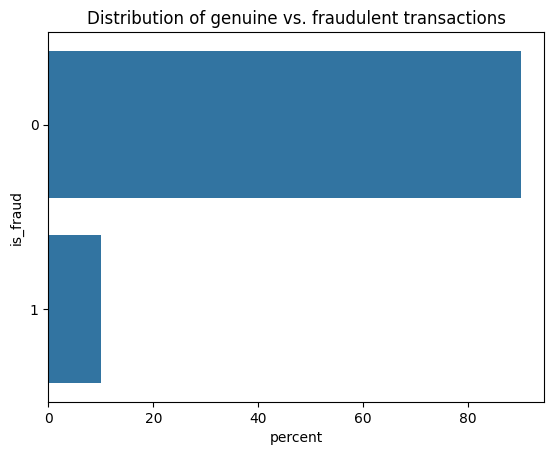

In [189]:
plt = sb.countplot(y = 'is_fraud',
            data = data, 
            orient = 'h',
            stat = 'percent')
            #order = data['Year'].value_counts().index)
plt.set_title('Distribution of genuine vs. fraudulent transactions')

Comments: About 10% of the transactions appear to be fraudulent transactions. There is class imbalance, and the ratio of genuine vs. fraudulent transactions is 9:1.

Categorical features and EDA

In [190]:
# how many unique values are there in the categorical variables?

print('Merchant:', data['merchant'].nunique())
print('Category:', data['category'].nunique())
print('Gender:', data['gender'].nunique())
print('City:', data['city'].nunique())
print('State:', data['state'].nunique())
print('Job title:', data['job'].nunique())

Merchant: 693
Category: 14
Gender: 2
City: 906
State: 51
Job title: 497


Comments: 
- Do visual analysis of fraudulent trans. distribution for category and gender.
- For merchant, city, state, job: visually inspect the distribution of fraudulent trans. for top 10 or 20.

For merchant, city, state, job: visually inspect the distribution of fraudulent trans. for top 10 or 20.

Text(0.5, 0, 'Proportion')

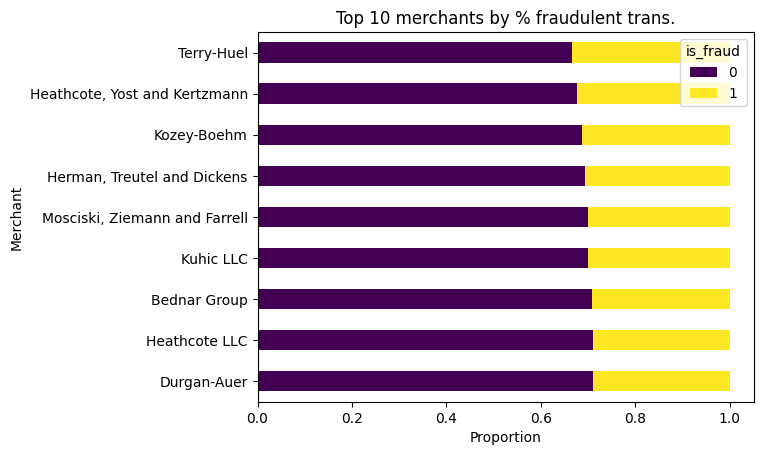

In [191]:
# get the relative % of fraud and legit trans by merchants
merchant_dist = (data.groupby(['merchant', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = merchant_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[0:9][::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Top 10 merchants by % fraudulent trans.')
plt.set_ylabel('Merchant')
plt.set_xlabel('Proportion')

Text(0.5, 0, 'Proportion')

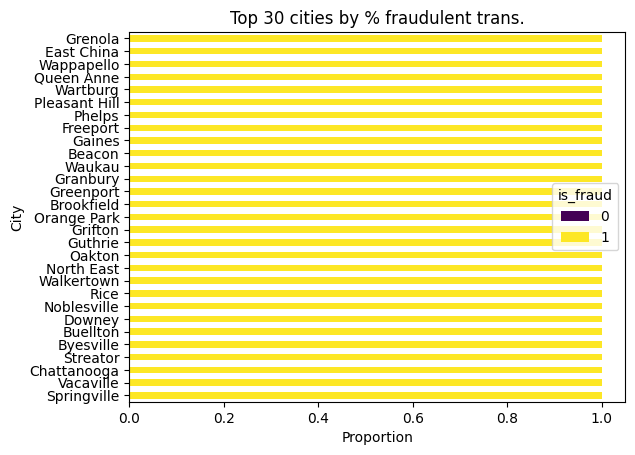

In [192]:
# get the relative % of fraud and legit trans by city
city_dist = (data.groupby(['city', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = city_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[0:29][::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Top 30 cities by % fraudulent trans.')
plt.set_ylabel('City')
plt.set_xlabel('Proportion')

Comments: In fact there are ~70 cities with relative risk of 100% fraudulent trans. 

Text(0.5, 0, 'Proportion')

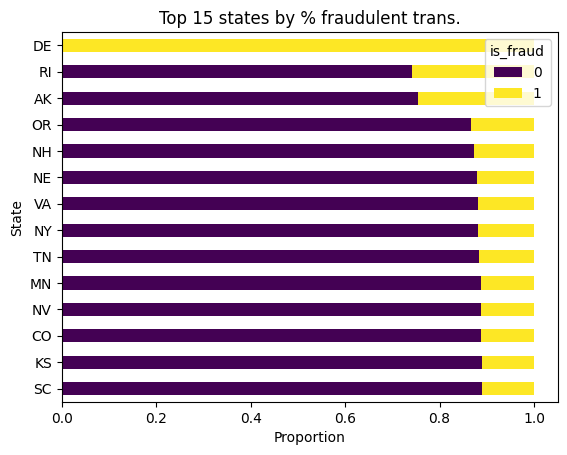

In [193]:
# get the relative % of fraud and legit trans by state
state_dist = (data.groupby(['state', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = state_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[0:14][::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Top 15 states by % fraudulent trans.')
plt.set_ylabel('State')
plt.set_xlabel('Proportion')

Text(0.5, 0, 'Proportion')

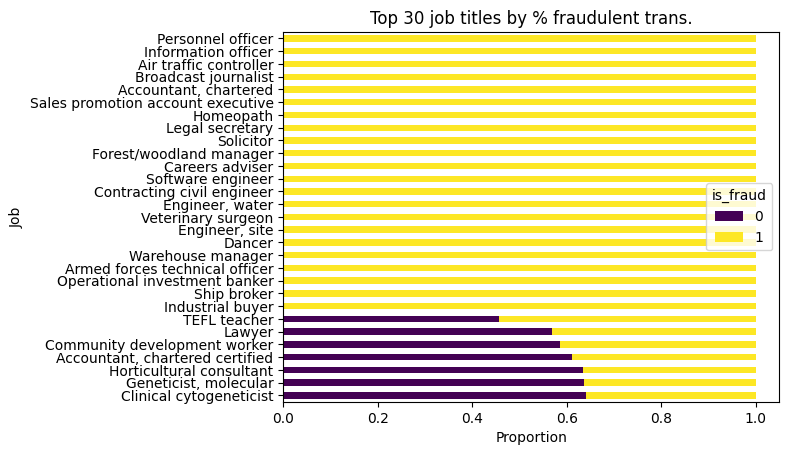

In [194]:
# get the relative % of fraud and legit trans by job
job_dist = (data.groupby(['job', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = job_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[0:29][::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Top 30 job titles by % fraudulent trans.')
plt.set_ylabel('Job')
plt.set_xlabel('Proportion')

Class balance check for gender and category

Text(0.5, 1.0, 'Distribution of category')

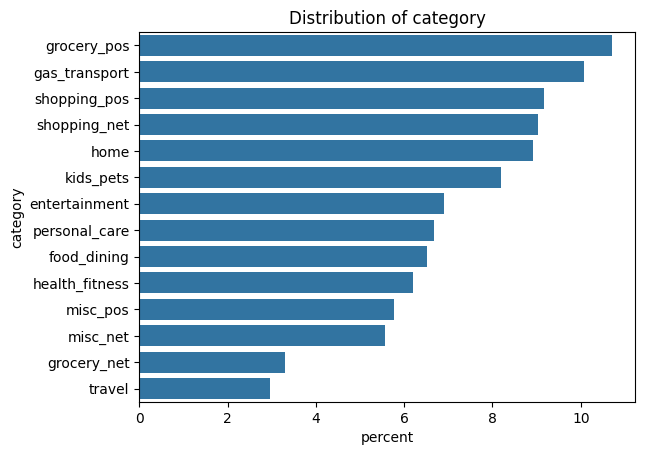

In [195]:
plt = sb.countplot(y = 'category',
            data = data, 
            orient = 'h',
            stat = 'percent',
            order = data['category'].value_counts().index)
plt.set_title('Distribution of category')

Comments: There appears to be some imbalance among the categories, but we assume that the distribution is representative of the population.

Text(0.5, 1.0, 'Distribution of gender')

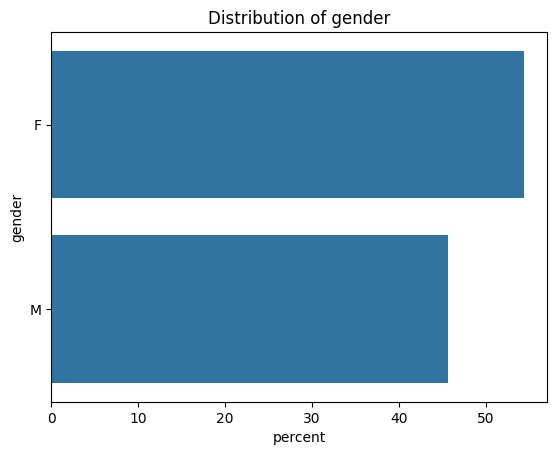

In [196]:
plt = sb.countplot(y = 'gender',
            data = data, 
            orient = 'h',
            stat = 'percent',
            order = data['gender'].value_counts().index)
plt.set_title('Distribution of gender')

Comments: The transactions by gender is ~55:45 (F:M) ratio.

Visual analysis of fraudulent trans. distribution for category and gender

Text(0.5, 0, 'Proportion')

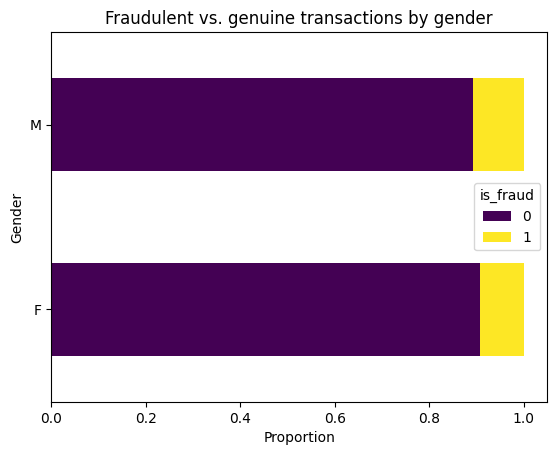

In [197]:
# get the relative % of fraud and legit trans by gender
gender_dist = (data.groupby(['gender', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = gender_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Fraudulent vs. genuine transactions by gender')
plt.set_ylabel('Gender')
plt.set_xlabel('Proportion')

Text(0.5, 0, 'Proportion')

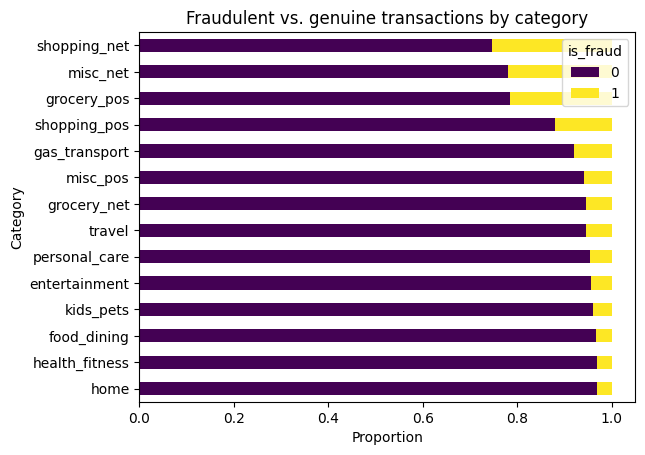

In [198]:
# get the relative % of fraud and legit trans by category
category_dist = (data.groupby(['category', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = category_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Fraudulent vs. genuine transactions by category')
plt.set_ylabel('Category')
plt.set_xlabel('Proportion')

Comments: 
- Drop the features - merchant, city, state, and job. For instance, merchants can't be separated as fraudulent and genuine for two reasons - it will lead to bias and uncertainty around future trans. 
- Keep gender and category.

Feature engineering of time-series

In [199]:
data['trans_date'] = pd.to_datetime(data['trans_datetime'])
data['trans_month'] = data['trans_date'].dt.month
data['trans_monthname'] = data['trans_date'].dt.month_name()
data['trans_year'] = data['trans_date'].dt.year

In [200]:
print('Year:', data['trans_year'].nunique())
print('Month:', data['trans_month'].nunique())
print('Month name:', data['trans_monthname'].nunique())

Year: 2
Month: 12
Month name: 12


Text(0.5, 0, 'Proportion')

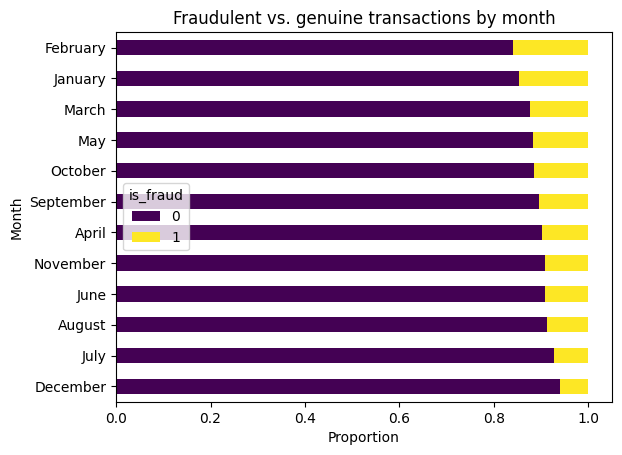

In [201]:
# get the relative % of fraud and legit trans by month
month_dist = (data.groupby(['trans_monthname', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = month_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Fraudulent vs. genuine transactions by month')
plt.set_ylabel('Month')
plt.set_xlabel('Proportion')

Comments: First quarter of the year appears to have higher % of fraudulent trans. compared to legitimate trans. It is interesting to see that December has the lowest % of fraudulent trans.

Text(0.5, 0, 'Proportion')

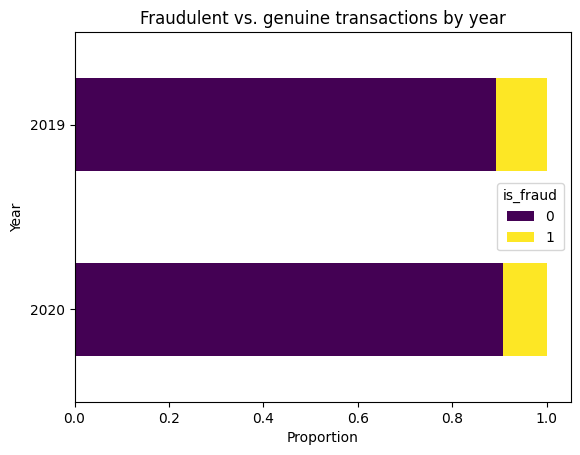

In [202]:
# get the relative % of fraud and legit trans by year
year_dist = (data.groupby(['trans_year', 'is_fraud'])
                .size()
                .unstack(fill_value=0)
                .transform(lambda x: x / x.sum(), axis=1))

sorted_props = year_dist.sort_values(1, ascending=False)

# Create the plot with sorted data
plt = sorted_props[::-1].plot(kind='barh', 
                 stacked=True,
                 colormap='viridis')

plt.set_title('Fraudulent vs. genuine transactions by year')
plt.set_ylabel('Year')
plt.set_xlabel('Proportion')

Comments: There is a slight decrease in % of fraudulent trans in 2020 compared to 2019.

##### Pairs plot

Scale the numeric features

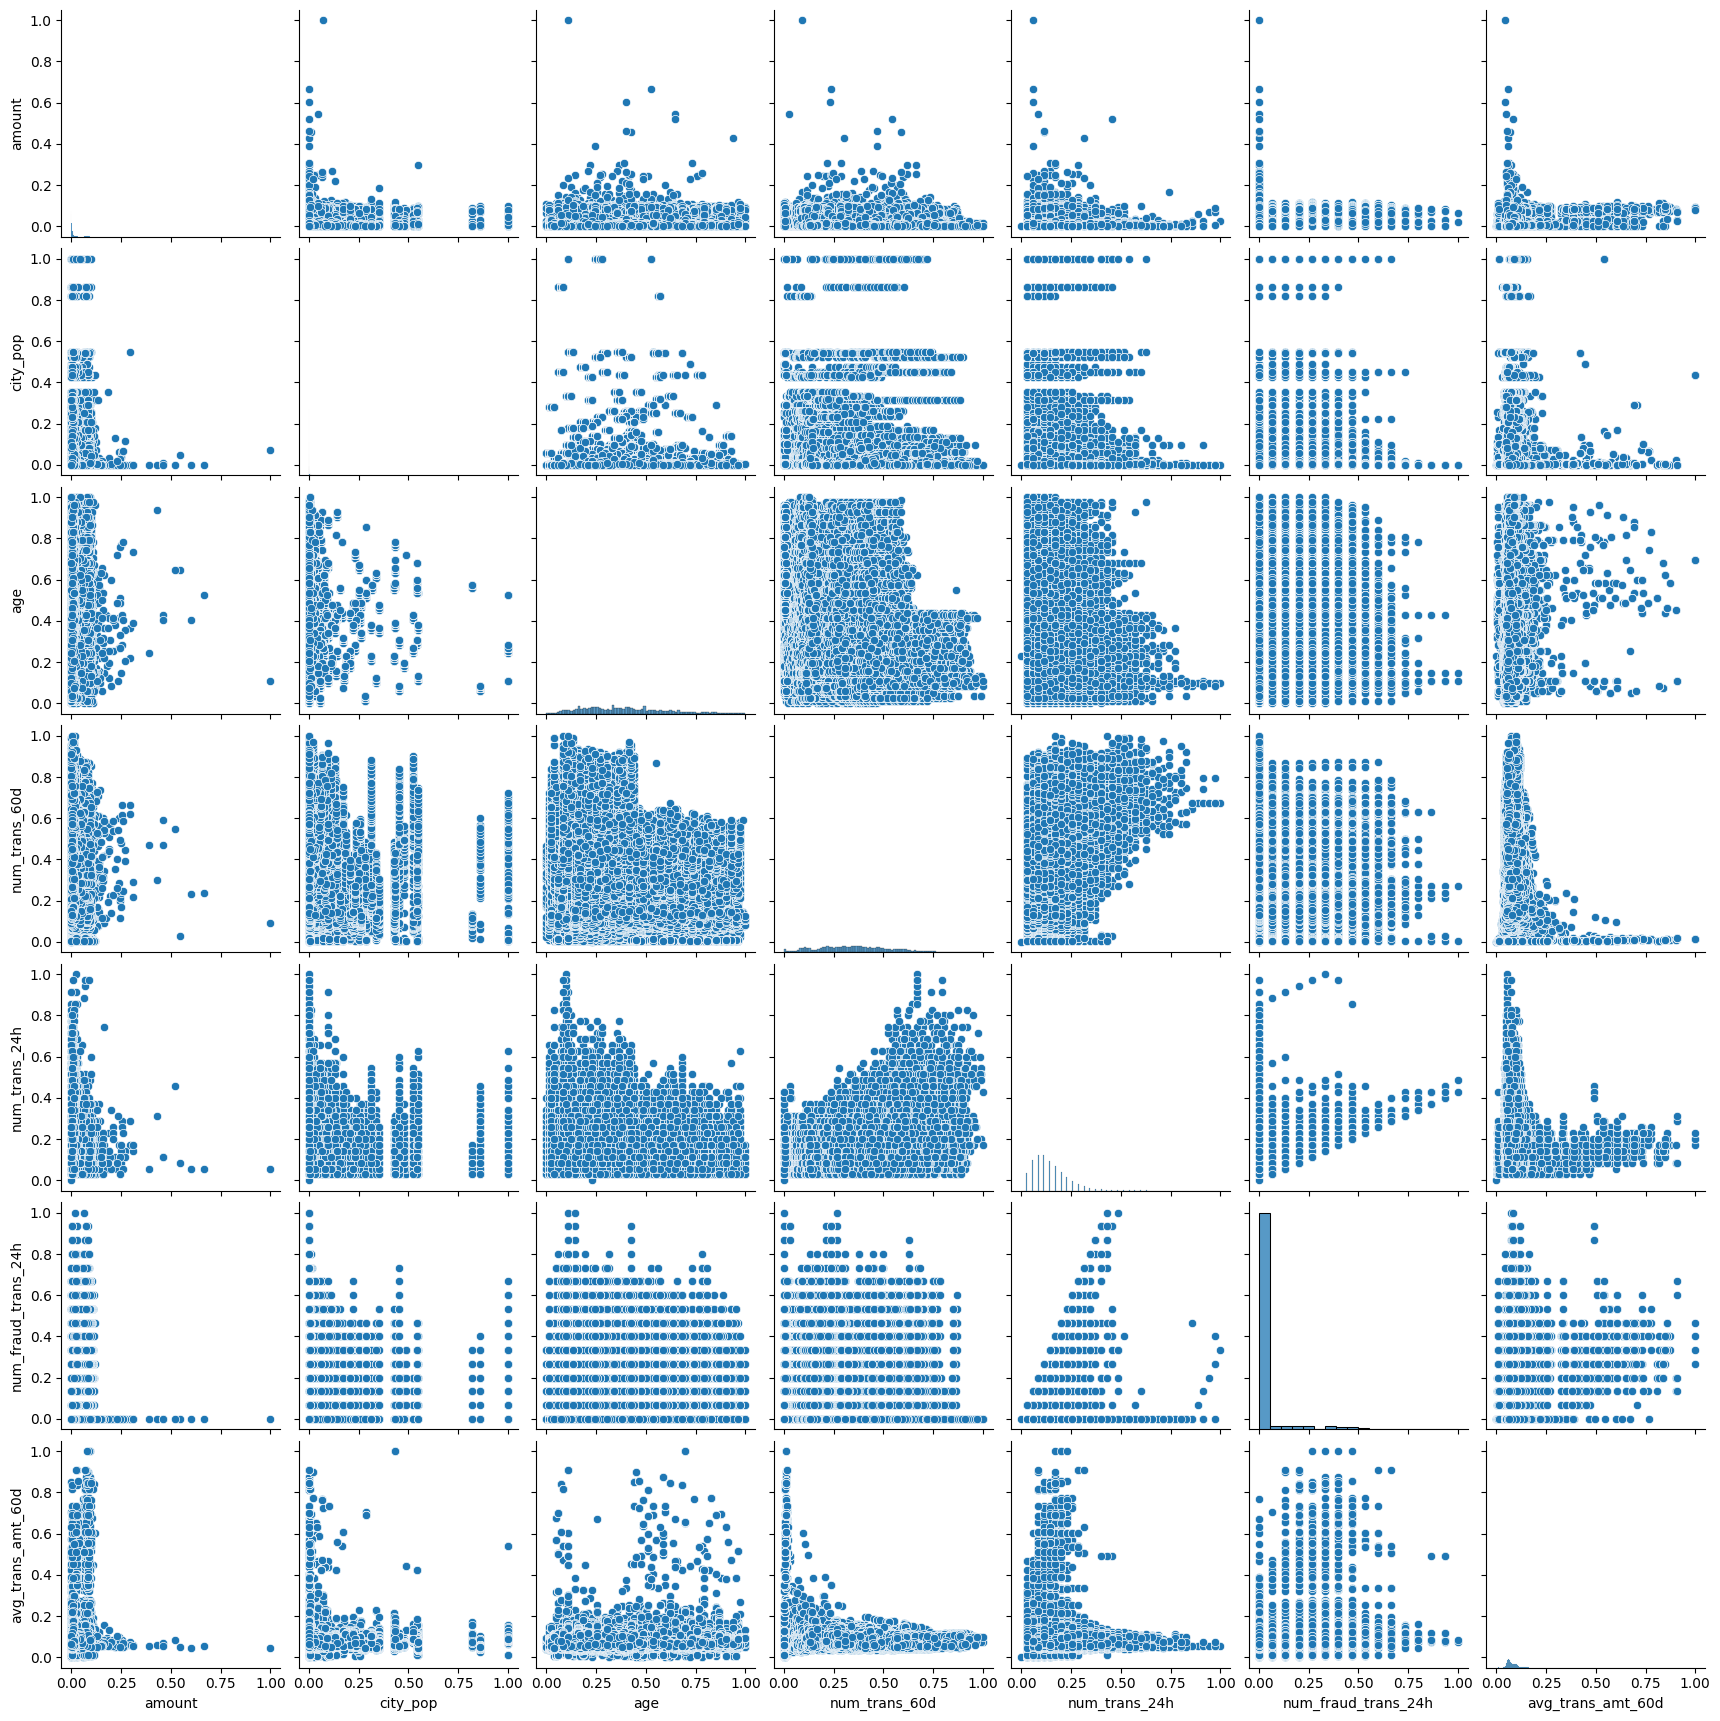

In [203]:
numeric_features = data[['amount',	'city_pop', 'age', 'num_trans_60d',	'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']]

# Scale
scaler = MinMaxScaler()
model = scaler.fit(numeric_features)

scaled_data = pd.DataFrame(model.transform(numeric_features))
scaled_data.columns = ['amount', 'city_pop', 'age', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']

# Visualise pairs plot
sb.pairplot(scaled_data)

Comments: 

- From the above pairs plot, we don't see strong correlation or multi-collinearity in the data.

Additional notes:
- The numeric features in the data don't have standardised scales/range, and there are outliers. Hence we scaled the features. 
- There are several scaling methods such as standardisation, min-max, robust scaler, etc. 
- In this context, we have used min-max scaling method. However, we could use quantile transformers scaling method for continuous numeric features, and min max for discrete numeric features.
    - For two reasons 
        - transforms the data into uniform Normal distribution through ranking and assigning quantiles,
        - Additionally, this method is robust to outliers as it maps the data to a specific range.

##### Correlation

Text(0.5, 1.0, 'Correlation heatmap')

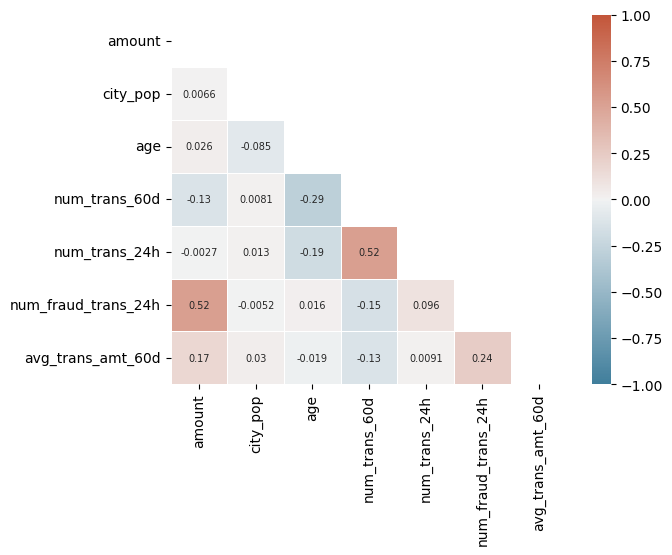

In [204]:
corr_mat = scaled_data.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Set up the matplotlib figure

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

sb.heatmap(corr_mat,
           annot=True,
           linewidth=.5,
           center=0,
           mask=mask,
           cmap=cmap, 
           vmin=-1, vmax=1,
           annot_kws={"size":7})
#plt.yticks(rotation=45)
plt.set_title('Correlation heatmap')

Comments: 

- The above correlation heatmap shows moderate postive correlation between 
    - amount and number of fraud trans in last 24 hours,
    - number of trans in 24 hours and trans in 60 days.

Let's analyse number of fraud transactions in 24 hours and fraud status

Text(0, 0.5, 'Transaction Count')

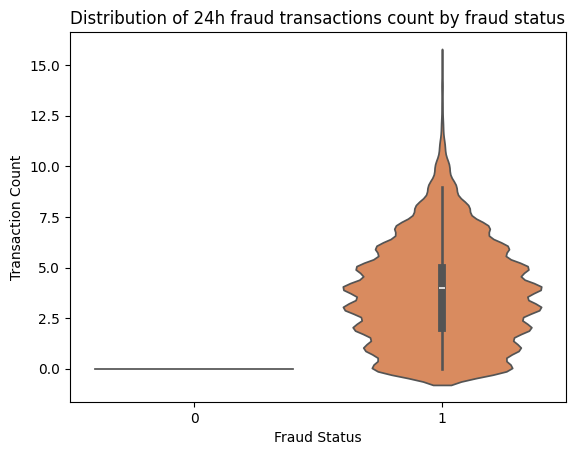

In [205]:
plt = sb.violinplot(data=data, x='is_fraud', y='num_fraud_trans_24h', palette='muted')
plt.set_title('Distribution of 24h fraud transactions count by fraud status')
plt.set_xlabel('Fraud Status')
plt.set_ylabel('Transaction Count')

Comments: This could lead to data leakage. The volume of fraud trans. increases only when a fraud transaction happens. Therefore, we should drop this feature.

Final data and features

In [206]:
data_backup = data
data = pd.concat([data[['category', 'gender', 'trans_month', 'trans_year']], scaled_data[['amount', 'city_pop', 'age', 'num_trans_60d', 'num_trans_24h', 'avg_trans_amt_60d']], data['is_fraud']], axis=1)

In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96510 entries, 0 to 96509
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           96510 non-null  object 
 1   gender             96510 non-null  object 
 2   trans_month        96510 non-null  int32  
 3   trans_year         96510 non-null  int32  
 4   amount             96510 non-null  float64
 5   city_pop           96510 non-null  float64
 6   age                96510 non-null  float64
 7   num_trans_60d      96510 non-null  float64
 8   num_trans_24h      96510 non-null  float64
 9   avg_trans_amt_60d  96510 non-null  float64
 10  is_fraud           96510 non-null  int64  
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 7.4+ MB


Comments: 
- We decided to drop features - cc_num, transdatetime, merchant, firstname, lastname, street, city, state, zip, lat, lon, and job.
- We have scaled the numeric features to standardise and treat outliers, and added new features trans month and year.
- We dropped num_fraud_trans_24h due to data leakage.
- Finally we have 10 input features and 1 target feature.

### b. Model building and evaluation

Review of EDA: 

- We have sample size of 96510 obs., and 11 input features and 1 target feature.

- There is no strong multi-collinearity among the features.

- There is class imbalance in the target feature - is_fraud and the ratio is 9:1, i.e., for every 10 transaction only 1 trans. is a fraudulent transaction.


One-hot encoding of data and split data into train-test 

In [208]:
# One hot encoding

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding
encoded = encoder.fit_transform(data[['category', 'gender']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['category', 'gender']))


In [209]:
data_encd = pd.concat([encoded_df, data[['trans_month', 'trans_year', 'amount', 'city_pop', 'age', 'num_trans_60d', 'num_trans_24h', 'avg_trans_amt_60d', 'is_fraud']]], axis=1)

In [210]:
# Split data
# Features (X) and target (y)
X = data_encd.drop(columns=['is_fraud'])
y = data_encd['is_fraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1201)

#### Logistic regression

Logistic regression assumptions:

- Sample data are independent of each other,
- response variable is a discrete distribution,
- number of successes associated with the an observation must be an integer between 0 and n,
- it accounts for non-constant variance in a sensible way.

##### Model building - Feature selection

In [211]:
# Define class weights manually (e.g., giving more weight to class 1)
class_weights = {0: 0.09, 1: 0.91}  # Class 1 has more weight


# Initialize the Logistic Regression model
logreg = LogisticRegression(class_weight=class_weights, 
                            fit_intercept=True,
                            random_state=1201)

# Recursive feature selection
rfecv = RFECV(
    estimator=logreg,
    step=1,
    cv=5,
    verbose=0,
    scoring='f1_macro',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(class_weight={0: 0.09, 1: 0.91},
                                   random_state=1201),
      n_jobs=-1, scoring='f1_macro')

Text(0, 0.5, 'F1-Score (Macro)')

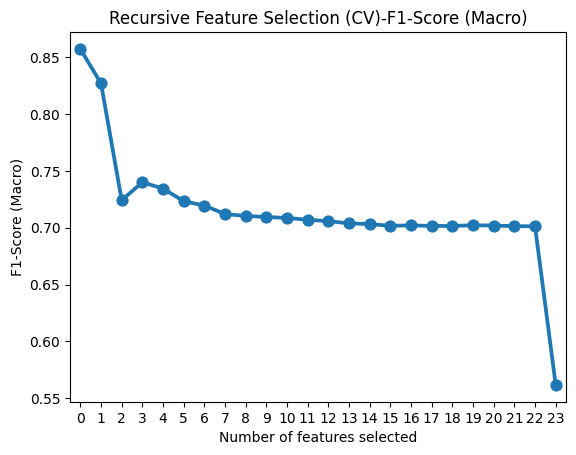

In [212]:
# Plot the CV performance
cv_results = pd.DataFrame(rfecv.cv_results_)

plt = sb.pointplot(
    data = cv_results,
    x = range(0,24),
    y = "mean_test_score",
    errorbar = "sd"
)
plt.set_title("Recursive Feature Selection (CV)-F1-Score (Macro)")
plt.set_xlabel('Number of features selected')
plt.set_ylabel("F1-Score (Macro)")

Statistical t-test to select the number of features - 4 or 5 features

In [213]:
sm.stats.ttest_ind(cv_results.iloc[3][2:7], cv_results.iloc[4][2:7])

(1.651972179310096, 0.13714341764213472, 8.0)

Comments: We have no evidence to reject our null hypothesis - suggesting that the model with 4 and 5 features are the same. Let's go with the model with 5 features.

In [214]:
# Recursive feature selection
rfecv = RFECV(
    estimator=logreg,
    step=1,
    cv=5,
    min_features_to_select=5,
    verbose=0,
    scoring='f1_macro',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(class_weight={0: 0.09, 1: 0.91},
                                   random_state=1201),
      min_features_to_select=5, n_jobs=-1, scoring='f1_macro')

In [215]:
# review the selected features
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {rfecv.support_}")  # Boolean mask of selected features
print(f"Feature ranking: {rfecv.ranking_}")

# Get the selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:", selected_features)

Optimal number of features: 5
Selected features: [False False False False  True False False False False False False False
 False False False False False False  True False False  True  True  True]
Feature ranking: [ 3  7  2 13  1  6  4  9 10 15 19 14  8 18 16 12 17 20  1  5 11  1  1  1]
Selected Features: Index(['category_grocery_pos', 'amount', 'num_trans_60d', 'num_trans_24h',
       'avg_trans_amt_60d'],
      dtype='object')


Comments: Let's interpret the model summary.

In [216]:
# Select the features
X_train_selected = X_train[selected_features]

# Add a constant (intercept) to the features (statsmodels requires an explicit intercept)
X_train_selected = sm.add_constant(X_train_selected)

# Fit the Logistic Regression model using statsmodels
model = sm.Logit(y_train, X_train_selected)
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.178878
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:                67557
Model:                          Logit   Df Residuals:                    67551
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Jan 2025   Pseudo R-squ.:                  0.4498
Time:                        14:55:45   Log-Likelihood:                -12084.
converged:                       True   LL-Null:                       -21962.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.6544      0.061    -60.163      0.000      -3.773      -3.535

Text(0.5, 1.0, 'Feature importance - Log(Odds)')

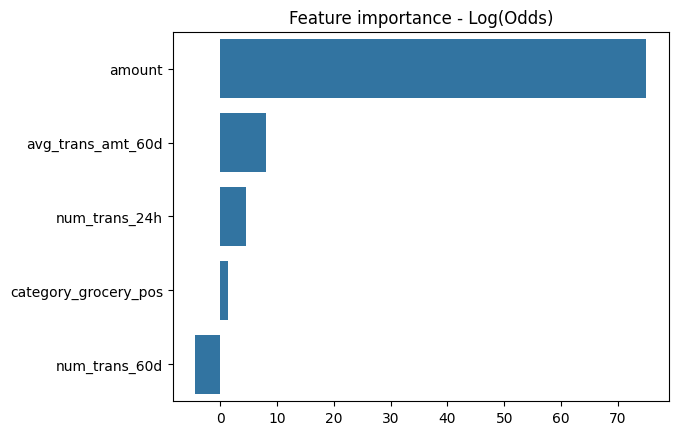

In [217]:
# Visualise the feature importance
plt = sb.barplot(result.params[1:].sort_values(ascending = False), 
                 orient = 'h')
plt.set_title('Feature importance - Log(Odds)')

##### Model evaluation

In [218]:
# Train Logistic Regression model with selected features
X_train_selected = X_train[selected_features]
logreg.fit(X_train_selected, y_train)

# Make predictions on the test set
X_test_selected = X_test[selected_features]
y_pred = logreg.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8738645390805788
Confusion Matrix:
[[23051  3007]
 [  645  2250]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93     26058
           1       0.43      0.78      0.55      2895

    accuracy                           0.87     28953
   macro avg       0.70      0.83      0.74     28953
weighted avg       0.92      0.87      0.89     28953



In [219]:
logreg_fpr, logreg_tpr, _ = metrics.roc_curve(y_test, y_pred)
logreg_auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

Note: In this context, we are interested in classifying fraudulent transactions. Therefore, we should pay attention to classifying is_fraud - 1 (Yes) compared to is_fraud - 0 (No).

Comments: 


- Look at the precision and recall rates for is_fraud: 1 (Yes). The model learned to classify fraudulent transactions based of the class weights, but it has come with cost of mis-classification.

- The model is able to correctly classify/detect fraudulent transactions ~43%, but we should try other models to see if we can improve the performance.


#### Naive Bayes classifier

Assumptions:
- The data are independent of each other,
- The prior distributions are not known explicitly,
- Continuous numeric features/predictors should have normal distribution.

Model building and evaluation

In [220]:
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB

# Build a Gaussian Classifier
NBclf = GaussianNB()

In [221]:
NBclf.fit(X_train_selected, y_train)

# Make predictions on the test set
X_test_selected = X_test[selected_features]
y_pred = NBclf.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9467067315994888
Confusion Matrix:
[[25541   517]
 [ 1026  1869]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     26058
           1       0.78      0.65      0.71      2895

    accuracy                           0.95     28953
   macro avg       0.87      0.81      0.84     28953
weighted avg       0.94      0.95      0.94     28953



In [222]:
NBclf_fpr, NBclf_tpr, _ = metrics.roc_curve(y_test, y_pred)
NBclf_auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

Comments: 

- The Naive Bayes classifier does better in classifying both genuine and fraudulent trans. compared to the logistic regression. There appears to be trade-offs between these two models.

- Trade-offs of detecting fraudulent trans.:
    - Logistic regression: Recall is higher and precision is lower (i.e., there is lot of false positives - legit trans. misclassified as fraud trans.),
    - Naive Bayes model: Precision is higher and recall is lower (i.e., there is false negatives - fraud trans. misclassified as legit trans.).

##### SVM classifier

Model building and evaluation

In [223]:
# import SVC classifier
from sklearn.svm import SVC

# instantiate classifier with default hyperparameters
svc=SVC(kernel='rbf', class_weight='balanced', random_state=1701) 

In [224]:
# Check if class weights are reflective of the data imbalance
len(X_train_selected)/(2*(np.bincount(y_train)))

array([0.5555583 , 4.99977798])

Comments: 

The class weight - “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [225]:
# fit classifier to training set
svc.fit(X_train_selected, y_train)

# make predictions on test set
y_pred=svc.predict(X_test_selected)

In [226]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9494007529444272
Confusion Matrix:
[[25216   842]
 [  623  2272]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     26058
           1       0.73      0.78      0.76      2895

    accuracy                           0.95     28953
   macro avg       0.85      0.88      0.86     28953
weighted avg       0.95      0.95      0.95     28953



In [227]:
svc_fpr, svc_tpr, _ = metrics.roc_curve(y_test, y_pred)
svc_auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

Comments: 

- The Macro-F1 score is 86%, 
- Particularly for fraudulent trans, the precision and recall looks better compared to logistic regression and Naive Bayes classifier.

##### kNN classifier

Model building using cross-validation

In [228]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [229]:
k_values = [i for i in range (1,31)]
scores = []
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski')
    score = cross_val_score(knn, X_train_selected, y_train, cv=5)
    scores.append(score)
    mean_scores.append(np.mean(score))

Visualise the performance

Text(0, 0.5, 'Accuracy Score')

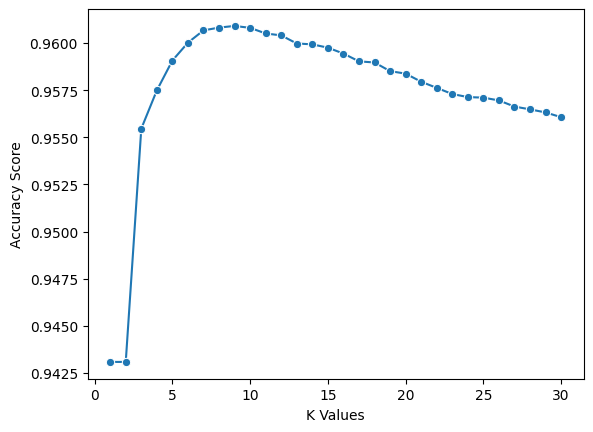

In [231]:
plt = sb.lineplot(x = k_values, y = mean_scores, marker = 'o')
plt.set_xlabel("K Values")
plt.set_ylabel("Accuracy Score")

Statistical t-test to select the number of k's - 7 or 9

In [ ]:
sm.stats.ttest_ind(scores[6], scores[8])

(-0.28477884730393194, 0.7830465394092728, 8.0)

Comments: Okay with either 7 or 9 neighbours.

Model evaluation

In [232]:
# fit classifier to training set
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski')
knn.fit(X_train_selected, y_train)

# make predictions on test set
y_pred=knn.predict(X_test_selected)

In [233]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9614893102614582
Confusion Matrix:
[[25789   269]
 [  846  2049]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26058
           1       0.88      0.71      0.79      2895

    accuracy                           0.96     28953
   macro avg       0.93      0.85      0.88     28953
weighted avg       0.96      0.96      0.96     28953



In [234]:
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test, y_pred)
knn_auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

Comments: k-NN has done a better job in classifying legit. transactions with higher precision and recall. Some misclassifications of false positives and negatives.

#### Model selection

Plot ROC curve and AUC

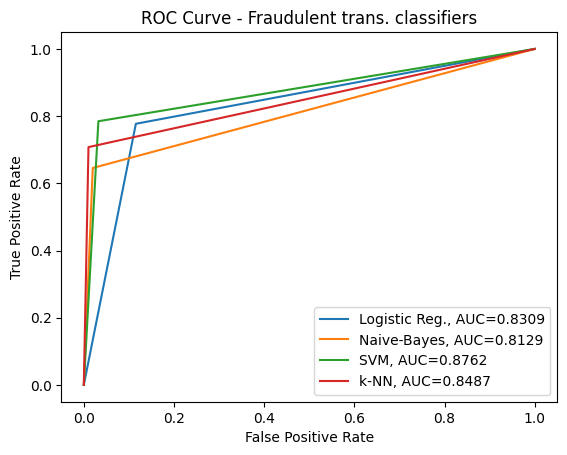

In [253]:
import matplotlib.pyplot as plt

plt.plot(logreg_fpr, logreg_tpr, label="Logistic Reg., AUC="+str(logreg_auc))
plt.plot(NBclf_fpr, NBclf_tpr, label="Naive-Bayes, AUC="+str(NBclf_auc))
plt.plot(svc_fpr, svc_tpr, label="SVM, AUC="+str(svc_auc))
plt.plot(knn_fpr, knn_tpr, label="k-NN, AUC="+str(knn_auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraudulent trans. classifiers')
plt.show()

Comments: The AUC is higher for SVM suggesting the classifier detects fraudulent trans. better than other models.